# Covariance for Angular Power Spectra with *Heracles*

This notebook demonstrates how *Heracles* computes an estimate of the covariance of the two-point statistics from a 3×2pt catalogue using the DICES method. This tutorial is heavily based on the summary statisitcs tutorial so we will reproduce the results found in said tutorial without going into the details of the analysis. We will then show how to compute the covariance of the angular power spectra using *Heracles*.

<div class="alert alert-info">

**Important note**

This notebook is only meant to give you an idea of **how *Heracles* works**.

It does **not** show everything that *Heracles* can do.

**This is a toy, treat it is such!**

</div>

## Setup

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import heracles
import heracles.healpy
from heracles.notebook import Progress

# Covariance code
import heracles.dices as dices

import helpers

with Progress("example data") as progress:
    helpers.get_example_data(progress)

VBox()

## Basic parameters

This is the resolution parameter for measuring spectra from *HEALPix* maps.  Here, we use `nside = 128` since that is the resolution at which the example data has been created. A value `lmax` of approximate 1.5x `nside` is fairly safe in terms of errors introduced by *HEALPix*. For the purpose of this tutorial we will only use 3 tomographic bins.

In [2]:
nside = 128
lmax = 150
nbins = 3

## Prepare maps

For this tutorial we will use the same data as in the summary statistics tutorial. Note that the maps generated in the summary statistics tutorial might have a different resolution. Therefore we will have to up/down-scale them accordingly. Doing so, unfortunately destroys the metadata of the maps. Therefore we will have to manually re-enter the metadata.

In [3]:
data_maps = heracles.read_maps("example-data_maps.fits")

In [4]:
data_maps = heracles.read_maps("example-data_maps.fits")
for key in list(data_maps.keys()):
    f, i = key
    if i <= nbins:
        _map = data_maps[key]
        meta = _map.dtype.metadata
        new_map = hp.ud_grade(_map, nside)
        heracles.update_metadata(
            new_map,
            nside=nside,
            lmax=lmax,
            bias=meta["bias"],
            fsky=meta["fsky"],
            spin=meta["spin"],
        )
        data_maps[key] = new_map
    else:
        data_maps.pop(key)

# load the FITS mask
vis_map = hp.read_map("vmap.fits.gz")
vis_map[vis_map == hp.UNSEEN] = 0.0
vis_map = hp.ud_grade(vis_map, nside)
heracles.update_metadata(
            vis_map,
            nside=nside,
            lmax=lmax,
            bias=0.0,
            fsky=meta["fsky"],
            spin=0,
        )
vis_maps = {}
for key in list(data_maps.keys()):
    f, i = key
    if f == "POS":
        f = "VIS"
    if f == "SHE":
        f = "WHT"
    key = (f, i)
    vis_maps[key] = vis_map

## Jackknife Regions

The fundamental idea behind Jackknife approaches is to generate an ensemble of angular power spectra by leaving out one of the regions at a time. The covariance of the angular power spectra can then be estimated from the variance of the ensemble. Therefore, the first step is to divide the mask of the survey into regions. In order to do so, in this tutorial we will make use of the SkySegmentor library. However, any library that segments the sky into regions can be used.

In [5]:
import skysegmentor

In [6]:
jk_maps = {}
Njk = 5
jk_map = skysegmentor.segmentmapN(vis_map, Njk)
for key in list(vis_maps.keys()):
    jk_maps[key] = jk_map

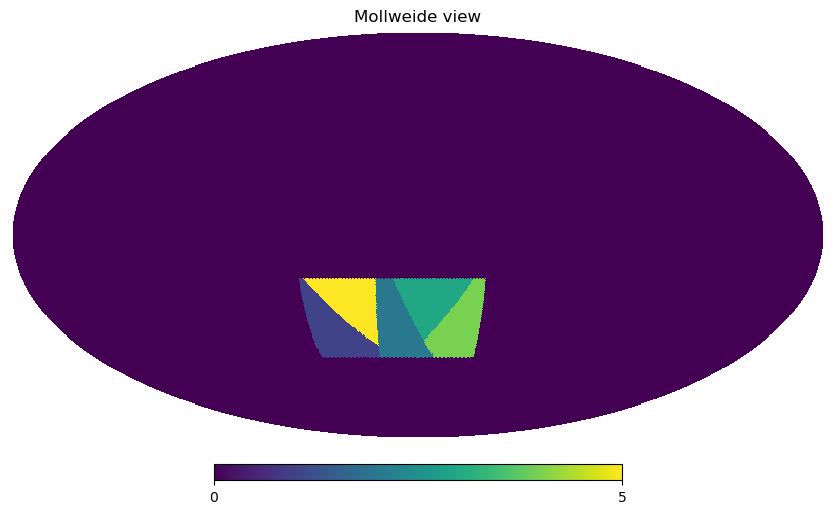

In [7]:
hp.mollview(jk_maps[("VIS", 1)])

## Two-point statistics

Since the computation of the two-point statistics was already covered in the summary statistics tutorial, we will not go into the details of the analysis. We will simply load the results from the summary statistics tutorial and use them to compute the covariance of the angular power spectra.

In [8]:
# TO DO: just 
cls0 = dices.get_cls(data_maps, jk_maps)
mls0 = dices.get_cls(vis_maps, jk_maps)

## Theory

Similarly, in this tutorial we will limit ourselves to loading the thoeory power spectra from the summary statistics tutorial.

In [9]:
theory = heracles.read("example-theory.fits")
for key in list(theory.keys()):
    f1, f2, i1, i2 = key
    if (i2 <= nbins) and (i1 <= nbins):
        if f1 == f2 == "POS":
            theory[key] = theory[key][: lmax + 1]
        else:
            theory[key] = theory[key][:, : lmax + 1]
    else:
        theory.pop(key)

## Ensemble Computation

Compute the ensemble of angular power spectrum effectively boils down to repeating the process presented in the two-point statistics section removing one of the jackknife regions at a time. However, a couple of extra considerations have to be made.
- When computing the angular power spectra from catalogues, removing one of the jackknife regions changes the sample variance of the angular power spectra by a factor of 
$$
b_{jk} = b (1-\frac{1}{N})
$$
- Moreover, removing of the jackknife regions also changes the footprint of the survey which can introduce additional mixing betweeen E- and B-modes. Heracles is equiped with a mask correction routine that corrects for this effect by transforming the angular power spectra to real space, dividing the correlation function of the ratio of new footprint to the old footprint and transforming back to harmonic space. 
$$
 C_\ell \rightarrow \xi(\theta) \\
 M_\ell \rightarrow \xi_m(\theta) \\
 M^{\rm jk}(\theta) \rightarrow \xi^{\rm jk}_m(\theta) \\
$$
$$
\bar{\xi}(\theta) = \xi(\theta) \frac{\xi_m(\theta)}{\xi^{\rm jk}_m(\theta)} \\
$$
$$
\bar{\xi}(\theta) \rightarrow \bar{C}_\ell
$$

In [10]:
cls1 = {}
for jk in range(1, Njk + 1):
    _cls = dices.get_cls(data_maps, jk_maps, jk=jk)
    _cls_mm = dices.get_cls(vis_maps, jk_maps, jk=jk)
    # Mask correction
    _cls = dices.correct_mask(_cls, _cls_mm, mls0)
    # Bias correction
    _cls = dices.correct_bias(
        _cls,
        jk_maps,
        jk,
        jk,
    )
    cls1[jk] = _cls

To add numerically stability to our computations, we will also bin the ensemble of angular power spectra.

In [11]:
nlbins = 10
ell = np.arange(lmax + 1)
ledges = np.logspace(np.log10(1), np.log10(lmax), nlbins + 1)
lgrid = (ledges[1:] + ledges[:-1]) / 2

In [12]:
cqs0 = heracles.binned(cls0, ledges)
cqs1 = heracles.binned(cls1, ledges)

## Jackknife Covariance & Shrinkage

In [13]:
delete1_cov = dices.get_delete1_cov(cqs0, cqs1)
W = dices.get_W(cqs1)
target_cov = dices.get_gaussian_target(cqs1)
shrinkage = dices.get_shrinkage(cqs0, target_cov, W)
shrunk_cov1 = dices.shrink_cov(
    cqs0,
    delete1_cov, 
    target_cov,
    shrinkage)

/home/jaimerzp/anaconda3/envs/gitd/lib/python3.13/site-packages/heracles/dices/delete1.py:264: RuntimeWarning: divide by zero encountered in scalar divide
  f[i, j] += np.sqrt(S[i, i] / S[j, j]) * get_covSS(j, j, i, j, W, Wbar)
/home/jaimerzp/anaconda3/envs/gitd/lib/python3.13/site-packages/heracles/dices/delete1.py:264: RuntimeWarning: invalid value encountered in scalar multiply
  f[i, j] += np.sqrt(S[i, i] / S[j, j]) * get_covSS(j, j, i, j, W, Wbar)
/home/jaimerzp/anaconda3/envs/gitd/lib/python3.13/site-packages/heracles/dices/delete1.py:263: RuntimeWarning: divide by zero encountered in scalar divide
  f[i, j] += np.sqrt(S[j, j] / S[i, i]) * get_covSS(i, i, i, j, W, Wbar)
/home/jaimerzp/anaconda3/envs/gitd/lib/python3.13/site-packages/heracles/dices/delete1.py:263: RuntimeWarning: invalid value encountered in scalar multiply
  f[i, j] += np.sqrt(S[j, j] / S[i, i]) * get_covSS(i, i, i, j, W, Wbar)
/home/jaimerzp/anaconda3/envs/gitd/lib/python3.13/site-packages/heracles/dices/delete1

In [18]:
def todatavector(result):
    
    nclss = 0
    nells = 0
    result = dices.Fields2Components(result)
    for key in result:
        cls = np.atleast_2d(result[key])
        ncls, nell = cls.shape
        nclss += ncls
        nells += ncls*nell

    datavector = np.zeros(nells)
    idx = {}
    for key in result:
        cls = np.atleast_2d(result[key])
        ncls, nell = cls.shape
        for i in range(ncls):
            datavector[i*nell:(i+1)*nell] = cls[i]
    
    idices = {}
    for i, key in enumerate(result):
        idices[key] = slice(i*nell, (i+1)*nell)
    return datavector

In [19]:
_c = heracles.Result(delete1_cov[(
    'G_E',
    'G_E',
    'G_E',
    'G_E',
    1,
    1,
    1,
    1,
)], ell=(lgrid, lgrid))
_c.axis

(0, 1)

In [20]:
todatavector(cqs0)

array([ 0.00000000e+00, -2.30128389e-12, -1.86310920e-11, -4.92685666e-11,
        5.36809899e-11, -1.64686426e-10, -7.53098891e-11, -3.37491606e-12,
       -9.29663364e-12,  8.04582018e-13,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

## Delete2 Covariance

In [21]:
cls2 = {}
for jk in range(1, Njk + 1):
    for jk2 in range(jk + 1, Njk + 1):
        _cls = dices.get_cls(data_maps, jk_maps, jk=jk, jk2=jk2,)
        _cls_mm = dices.get_cls(vis_maps, jk_maps, jk=jk, jk2=jk2)
        # Mask correction
        _cls = dices.correct_mask(_cls, _cls_mm, mls0)
        # Bias correction
        _cls = dices.correct_bias(
            _cls,
            jk_maps,
            jk,
            jk2,
        )
        cls2[(jk, jk2)] = _cls

In [22]:
cqs2 = heracles.binned(cls2, ledges)

In [ ]:
def gget_delete2_correction(Cls0, Clsjks, Clsjk2s):
    """
    Internal method to compute the delete2 covariance.
    inputs:
        Cls0 (dict): Dictionary of data Cls
        Clsjks (dict): Dictionary of delete1 data Cls
        Clsjk2s (dict): Dictionary of delete2 data Cls
    returns:
        Cljk_cov (dict): Dictionary of delete2 covariance
    """
    # Get JackNJk
    JackNjk = len(Clsjks.keys())

    # Bin Cls
    Cqs0 = dices.Fields2Components(Cls0)
    Cqs0_all = np.concatenate([Cqs0[key] for key in list(Cqs0.keys())])
    Cqsjks_all = []
    for key in Clsjks.keys():
        cls = dices.Fields2Components(Clsjks[key])
        cls_all = np.concatenate([cls[key] for key in list(cls.keys())])
        Cqsjks_all.append(cls_all)

    jk1 = []
    jk2 = []
    Cqsjks2 = []
    for jk in range(1, JackNjk):
        _jk2 = np.arange(jk + 1, JackNjk + 1)
        _jk1 = jk * np.ones(len(_jk2))
        _jk1 = _jk1.astype("int")
        _jk2 = _jk2.astype("int")
        _Clsjks = []
        for __jk2 in _jk2:
            cqs = Clsjk2s[(jk, __jk2)]
            cqs = dices.Fields2Components(cqs)
            cqs_all = np.concatenate([cqs[key] for key in list(cqs.keys())])
            _Clsjks.append(cqs_all)
        jk1.append(_jk1)
        jk2.append(_jk2)
        [Cqsjks2.append(_Cls) for _Cls in _Clsjks]
    jk1 = np.concatenate(jk1)
    jk2 = np.concatenate(jk2)

    # Compute bias correction
    Qii = []
    for i in range(0, len(Cqsjks2)):
        i1 = jk1[i]
        i2 = jk2[i]
        _Qii = JackNjk * Cqs0_all
        _Qii -= (JackNjk - 1) * (Cqsjks_all[i1 - 1] + Cqsjks_all[i2 - 1])
        _Qii += (JackNjk - 2) * Cqsjks2[i]
        Qii.append(_Qii)

    return Qii

In [42]:
_Qii = gget_delete2_correction(cqs0, cqs1, cqs2)

NameError: name 'Cqsjks' is not defined

In [34]:
len(_Qii)

10

In [25]:
Q = dices.get_delete2_correction(cqs0, cqs1, cqs2)

In [26]:
delete2_cov = dices.get_delete2_cov(
    delete1_cov,
    cqs0,
    cqs1,
    cqs2,
)

In [27]:
# for key in delete1
# Q_i = Q[key]
# _cov1 = cov1[key]
# _cov2 = _cov1 - Q_i

## DICES Covariance

In [28]:
dices_cov = dices.get_dices_cov(cqs0, delete1_cov, delete2_cov)

/home/jaimerzp/anaconda3/envs/gitd/lib/python3.13/site-packages/heracles/dices/utils_cl.py:255: RuntimeWarning: divide by zero encountered in divide
  corr /= np.outer(sig, sig)
/home/jaimerzp/anaconda3/envs/gitd/lib/python3.13/site-packages/heracles/dices/utils_cl.py:255: RuntimeWarning: invalid value encountered in divide
  corr /= np.outer(sig, sig)
/home/jaimerzp/anaconda3/envs/gitd/lib/python3.13/site-packages/heracles/dices/dices.py:50: RuntimeWarning: invalid value encountered in multiply
  dices_cov = _corr2 * _corr1


In [29]:
_delete1_cov = dices.cov2spinblocks(cqs0, delete1_cov)
_dices_cov = dices.cov2spinblocks(cqs0, dices_cov)

## Results

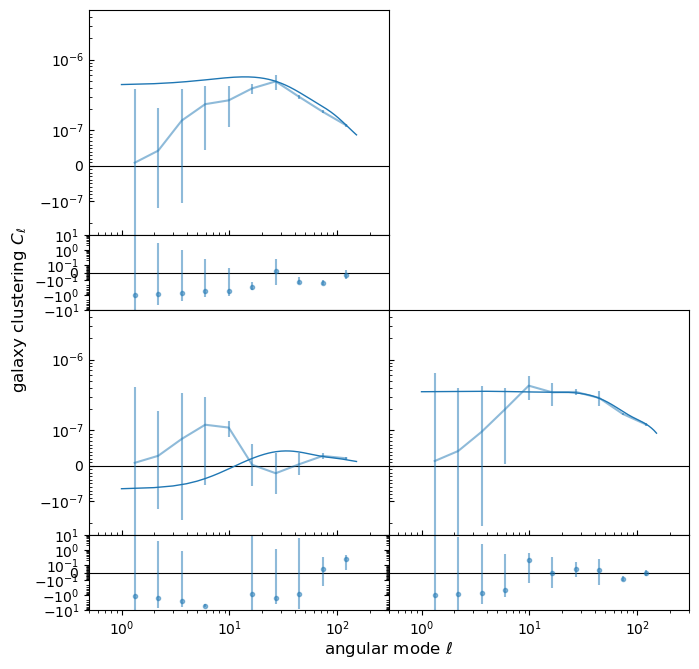

In [30]:
fig, ax = plt.subplots(
    2 * (nbins - 1),
    nbins - 1,
    figsize=(6, 6),
    gridspec_kw={"height_ratios": [3, 1, 3, 1]},
)


for i in range(1, nbins):
    for j in range(1, i):
        ax[j - 1, i - 1].axis("off")
        ax[j, i - 1].axis("off")
    for j in range(i, nbins):
        key = ("POS", "POS", i, j)
        cov_key = ("POS", "POS", "POS", "POS", i, j, i, j)
        c = _dices_cov[cov_key][0, 0, :, :]
        err = np.sqrt(np.diag(c))
        ax[2 * (j - 1), i - 1].errorbar(
            lgrid, cqs0[key], yerr=err, c="C0", lw=1.5, zorder=3.0, alpha=0.5
        )
        ax[2 * (j - 1), i - 1].plot(
            ell[1:], theory[key][1:], c="C0", lw=1.0, zorder=4.0
        )
        ax[2 * (j - 1), i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[2 * (j - 1) + 1, i - 1].errorbar(
            lgrid,
            (cqs0[key][:] - heracles.binned(theory[key][1:], ledges))
            / heracles.binned(theory[key][1:], ledges),
            yerr=np.abs(err / cqs0[key][:]),
            fmt=".",
            c="C0",
            lw=1.5,
            zorder=1.0,
            alpha=0.5,
        )
        ax[2 * (j - 1) + 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)

        ax[2 * (j - 1), i - 1].tick_params(axis="both", which="both", direction="in")
        ax[2 * (j - 1), i - 1].set_yscale(
            "symlog", linthresh=1e-7, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
        )
        ax[2 * (j - 1), i - 1].set_ylim(-3e-7, 5e-6)
        ax[2 * (j - 1) + 1, i - 1].set_yscale(
            "symlog", linthresh=0.1, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
        )
        ax[2 * (j - 1) + 1, i - 1].set_ylim(-10, 10)

        ax[2 * (j - 1), i - 1].set_xscale("log")
        ax[2 * (j - 1), i - 1].set_xlim(1 / 2, lmax * 2)
        ax[2 * (j - 1) + 1, i - 1].set_xscale("log")
        ax[2 * (j - 1) + 1, i - 1].set_xlim(1 / 2, lmax * 2)
        if i > 1:
            ax[2 * (j - 1), i - 1].set_yticklabels([])
            ax[2 * (j - 1) + 1, i - 1].set_yticklabels([])


fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel("galaxy clustering $C_\\ell$", x=-0.1, ha="right")

plt.show()

/tmp/ipykernel_59725/2067043606.py:35: RuntimeWarning: invalid value encountered in divide
  yerr=np.abs(e_err / cqs0[key][0, :]),


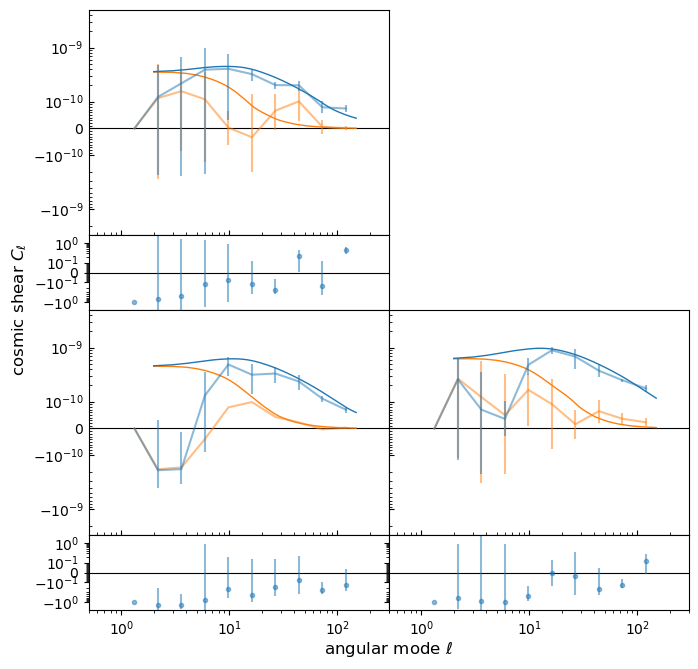

In [31]:
fig, ax = plt.subplots(
    2 * (nbins - 1),
    nbins - 1,
    figsize=(6, 6),
    gridspec_kw={"height_ratios": [3, 1, 3, 1]},
)

for i in range(1, nbins):
    for j in range(1, i):
        ax[j - 1, i - 1].axis("off")
        ax[j, i - 1].axis("off")
    for j in range(i, nbins):
        key = ("SHE", "SHE", i, j)
        cov_key = ("SHE", "SHE", "SHE", "SHE", i, j, i, j)
        e_c = _delete1_cov[cov_key][0, 0]
        e_err = np.sqrt(np.diag(e_c))
        b_c = _delete1_cov[cov_key][1, 1]
        b_err = np.sqrt(np.diag(b_c))
        ax[2 * (j - 1), i - 1].errorbar(
            lgrid,
            cqs0[key][0, :],
            yerr=e_err,
            c="C0",
            lw=1.5,
            zorder=3.0,
            alpha=0.5,
        )
        ax[2 * (j - 1), i - 1].plot(
            ell[2:], theory[key][0, 2:], c="C0", lw=1.0, zorder=4.0
        )
        ax[2 * (j - 1) + 1, i - 1].errorbar(
            lgrid,
            (cqs0[key][0, :] - heracles.binned(theory[key][0, 2:], ledges))
            / heracles.binned(theory[key][0, 2:], ledges),
            yerr=np.abs(e_err / cqs0[key][0, :]),
            fmt=".",
            c="C0",
            lw=1.5,
            zorder=1.0,
            alpha=0.5,
        )
        ax[2 * (j - 1), i - 1].errorbar(
            lgrid,
            cqs0[key][1, :],
            yerr=b_err,
            c="C1",
            lw=1.5,
            zorder=1.0,
            alpha=0.5,
        )
        ax[2 * (j - 1), i - 1].plot(
            ell[2:],
            theory[key][1, 2:],
            c="C1",
            lw=1.0,
            zorder=2.0,
        )
        ax[2 * (j - 1), i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[2 * (j - 1) + 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[2 * (j - 1), i - 1].tick_params(axis="both", which="both", direction="in")
        ax[2 * (j - 1), i - 1].set_yscale(
            "symlog", linthresh=1e-10, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
        )
        ax[2 * (j - 1), i - 1].set_ylim(-3e-9, 5e-9)
        ax[2 * (j - 1) + 1, i - 1].set_yscale(
            "symlog", linthresh=0.1, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
        )
        ax[2 * (j - 1) + 1, i - 1].set_ylim(-2.5, 2.5)

        ax[2 * (j - 1), i - 1].set_xscale("log")
        ax[2 * (j - 1), i - 1].set_xlim(1 / 2, lmax * 2)
        ax[2 * (j - 1) + 1, i - 1].set_xscale("log")
        ax[2 * (j - 1) + 1, i - 1].set_xlim(1 / 2, lmax * 2)
        if i > 1:
            ax[2 * (j - 1), i - 1].set_yticklabels([])
            ax[2 * (j - 1) + 1, i - 1].set_yticklabels([])
ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
ax[0, 0].xaxis.get_minor_locator().set_params(
    numticks=99, subs=np.arange(0.1, 1.0, 0.1)
)
# ax[0, 0].set_yscale(
#    "symlog", linthresh=1e-10, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
# )
# ax[0, 0].set_ylim(-3e-7, 5e-7)

fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel("cosmic shear $C_\\ell$", x=-0.1, ha="right")

plt.show()

/tmp/ipykernel_59725/2986346763.py:15: RuntimeWarning: invalid value encountered in sqrt
  b_err = np.sqrt(np.diag(b_c))
/tmp/ipykernel_59725/2986346763.py:32: RuntimeWarning: divide by zero encountered in divide
  yerr=np.abs(e_err / cqs0[key][0, :]),
/tmp/ipykernel_59725/2986346763.py:15: RuntimeWarning: invalid value encountered in sqrt
  b_err = np.sqrt(np.diag(b_c))
/tmp/ipykernel_59725/2986346763.py:32: RuntimeWarning: divide by zero encountered in divide
  yerr=np.abs(e_err / cqs0[key][0, :]),


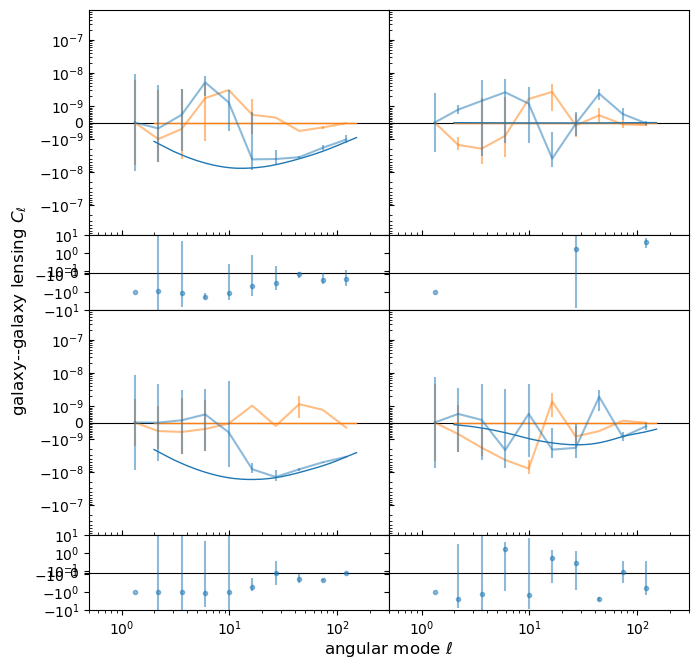

In [32]:
fig, ax = plt.subplots(
    2 * (nbins - 1),
    (nbins - 1),
    figsize=(6, 6),
    gridspec_kw={"height_ratios": [3, 1, 3, 1]},
)

for i in range(1, nbins):
    for j in range(1, nbins):
        key = ("POS", "SHE", i, j)
        cov_key = ("POS", "SHE", "POS", "SHE", i, j, i, j)
        e_c = _dices_cov[cov_key][0, 0]
        e_err = np.sqrt(np.diag(e_c))
        b_c = _dices_cov[cov_key][0, 1]
        b_err = np.sqrt(np.diag(b_c))
        ax[2 * (j - 1), i - 1].errorbar(
            lgrid,
            cqs0[key][0, :],
            yerr=e_err,
            c="C0",
            lw=1.5,
            zorder=3.0,
            alpha=0.5,
        )
        ax[2 * (j - 1), i - 1].plot(
            ell[2:], theory[key][0, 2:], c="C0", lw=1.0, zorder=4.0
        )
        ax[2 * (j - 1) + 1, i - 1].errorbar(
            lgrid,
            (cqs0[key][0, :] - heracles.binned(theory[key][0, 2:], ledges))
            / heracles.binned(theory[key][0, 2:], ledges),
            yerr=np.abs(e_err / cqs0[key][0, :]),
            fmt=".",
            c="C0",
            lw=1.5,
            zorder=1.0,
            alpha=0.5,
        )
        ax[2 * (j - 1), i - 1].errorbar(
            lgrid,
            cqs0[key][1, :],
            yerr=b_err,
            c="C1",
            lw=1.5,
            zorder=1.0,
            alpha=0.5,
        )
        ax[2 * (j - 1), i - 1].plot(
            ell[2:], theory[key][1, 2:], c="C1", lw=1.0, zorder=2.0
        )
        ax[2 * (j - 1), i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[2 * (j - 1) + 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[2 * (j - 1), i - 1].tick_params(axis="both", which="both", direction="in")

        ax[2 * (j - 1), i - 1].set_yscale(
            "symlog", linthresh=1e-9, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
        )
        ax[2 * (j - 1), i - 1].set_ylim(-8e-7, 8e-7)
        ax[2 * (j - 1) + 1, i - 1].set_yscale(
            "symlog",
            linthresh=0.1,
            linscale=0.1,
        )
        ax[2 * (j - 1) + 1, i - 1].set_ylim(-10, 10)

        ax[2 * (j - 1), i - 1].set_xscale("log")
        ax[2 * (j - 1), i - 1].set_xlim(1 / 2, lmax * 2)
        ax[2 * (j - 1) + 1, i - 1].set_xscale("log")
        ax[2 * (j - 1) + 1, i - 1].set_xlim(1 / 2, lmax * 2)
        if i > 1:
            ax[2 * (j - 1), i - 1].set_yticklabels([])
            ax[2 * (j - 1) + 1, i - 1].set_yticklabels([])

# ax[0, 0].set_xscale("log")
# ax[0, 0].set_xlim(1 / 2, lmax * 2)
ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
ax[0, 0].xaxis.get_minor_locator().set_params(
    numticks=99, subs=np.arange(0.1, 1.0, 0.1)
)
# ax[0, 0].set_yscale(
#    "symlog", linthresh=1e-9, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
# )
# ax[0, 0].set_ylim(-8e-7, 4e-7)

fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel("galaxy--galaxy lensing $C_\\ell$", x=-0.1, ha="right")

plt.show()